# Importing Libraries

In [253]:
import pandas as pd
import pmdarima as pm
from matplotlib import pyplot as plt
from utils.metrics import evaluate
from utils.plots import bar_metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

plt.style.use('bmh')
%matplotlib inline

ModuleNotFoundError: No module named 'fbprophet'

# Reading Datasets

In [202]:
df=pd.read_csv("dataset/air_pollution.csv" ,parse_dates=['date'])
df.set_index('date', inplace=True)
df.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


# Dropping unused columns

In [203]:
df.drop(['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'pollution_yesterday'], axis=1, inplace=True)
df.head()

,pollution_today
date,
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333
2010-01-06,56.416667


In [204]:
#getting dataset insight
df.describe()

,pollution_today
count,1825.000000
mean,98.245080
std,76.807697
min,3.166667
25%,42.333333
50%,79.166667
75%,131.166667
max,541.895833


In [205]:
#checking for null values
df.isnull().any()

pollution_today    False
dtype: bool

# Plotting

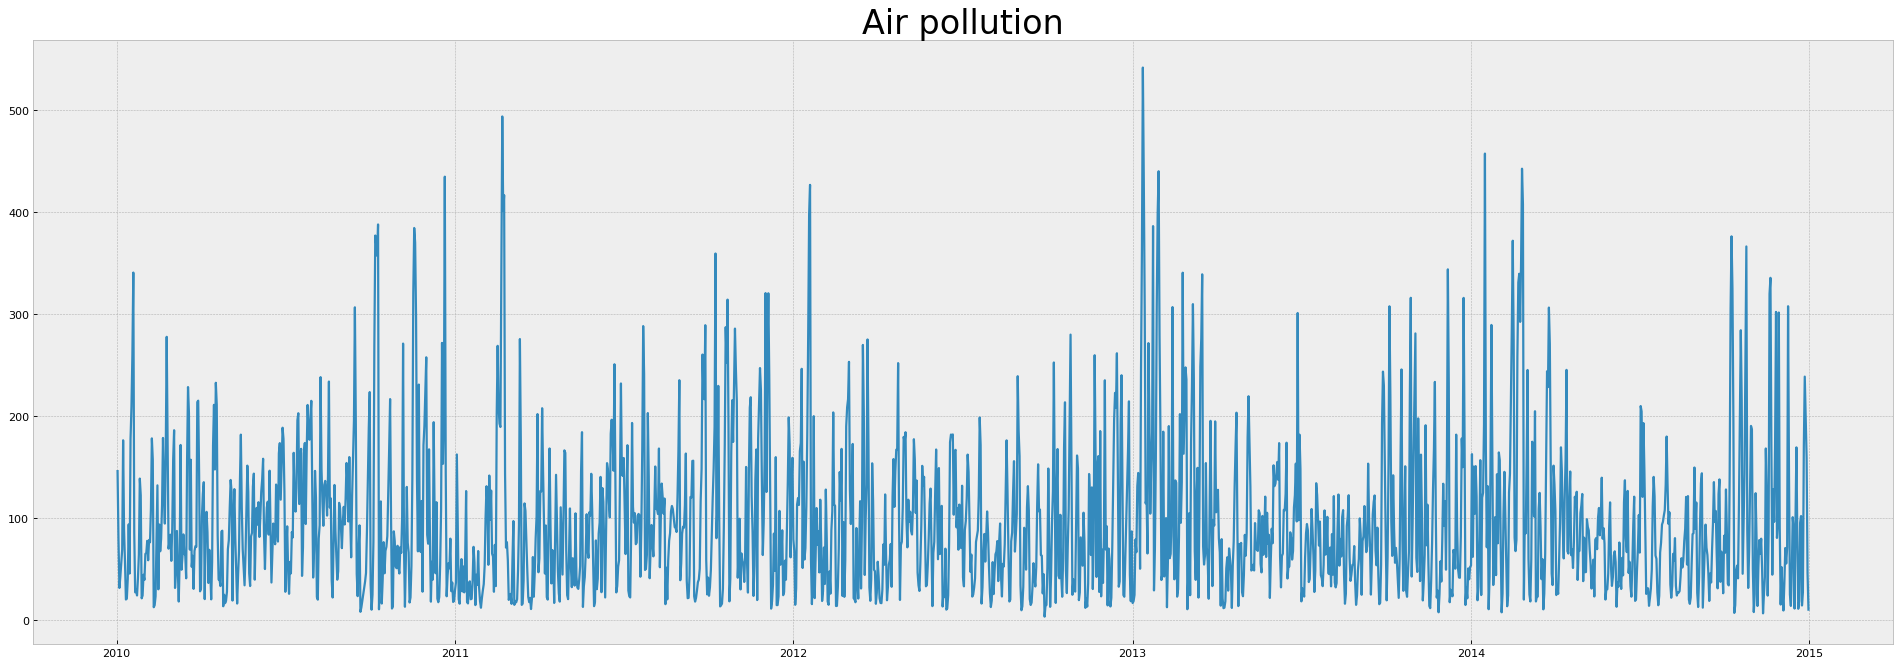

In [206]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(df["pollution_today"])

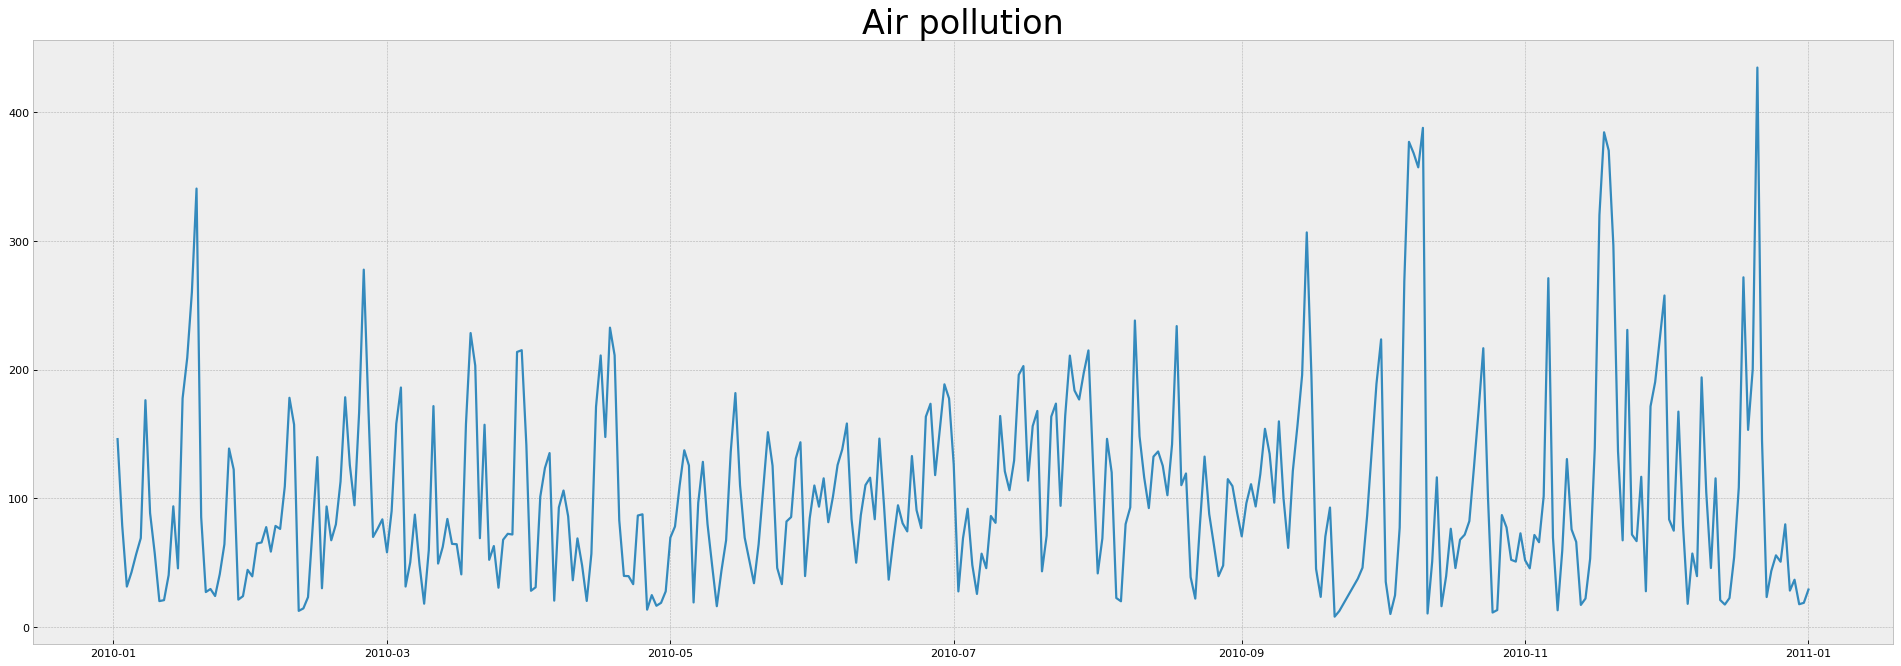

In [207]:
# plotting for a single year

plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(df["pollution_today"][:365])


# Time Resampling

<AxesSubplot:xlabel='date'>

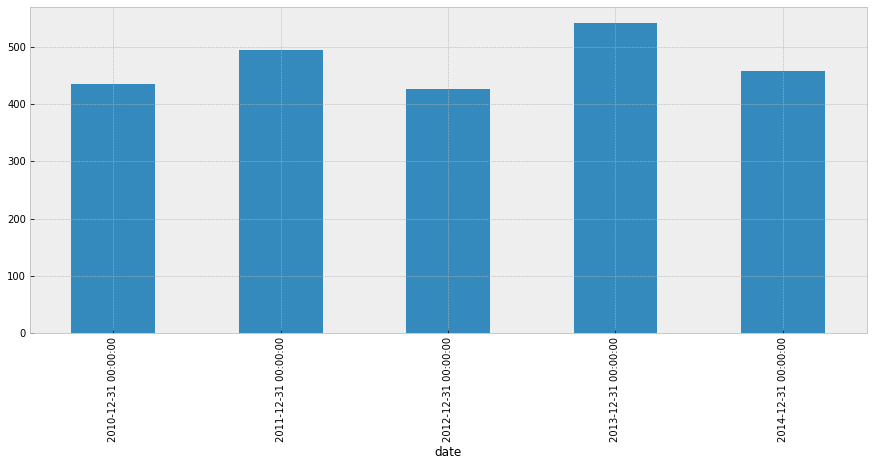

In [208]:
#Insight of pollution by Year
df['pollution_today'].resample(rule='A').max()
df['pollution_today'].resample(rule='A').max().plot(kind='bar',figsize=(15,6))


<AxesSubplot:xlabel='date'>

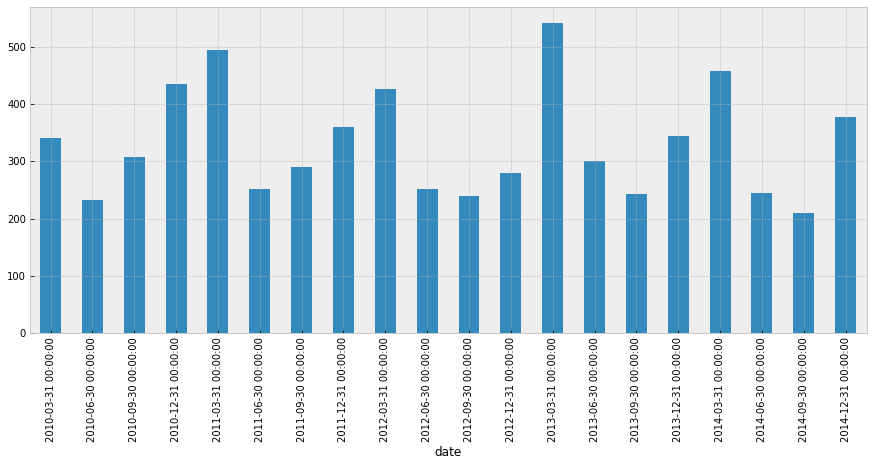

In [209]:
#Insight of pollution by Quartar
df['pollution_today'].resample(rule='Q').max()
df['pollution_today'].resample(rule='Q').max().plot(kind='bar',figsize=(15,6))



<AxesSubplot:xlabel='date'>

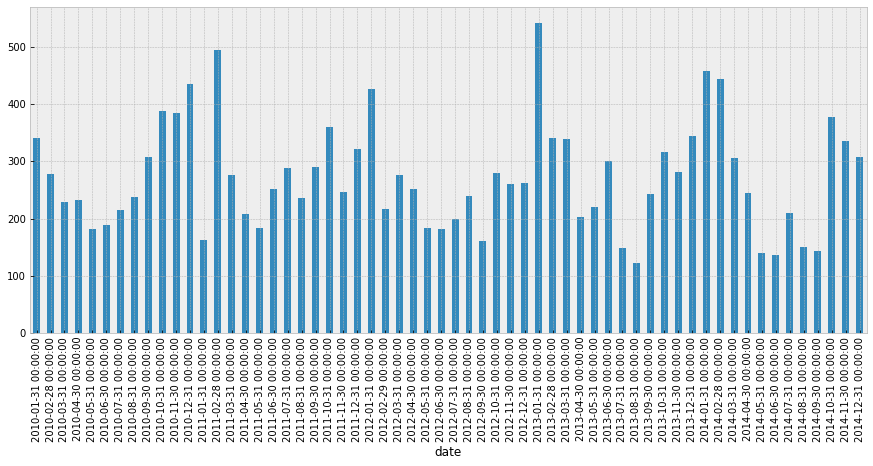

In [210]:

#Insight of pollution by Month
df['pollution_today'].resample(rule='M').max()
df['pollution_today'].resample(rule='M').max().plot(kind='bar',figsize=(15,6))



<AxesSubplot:xlabel='date'>

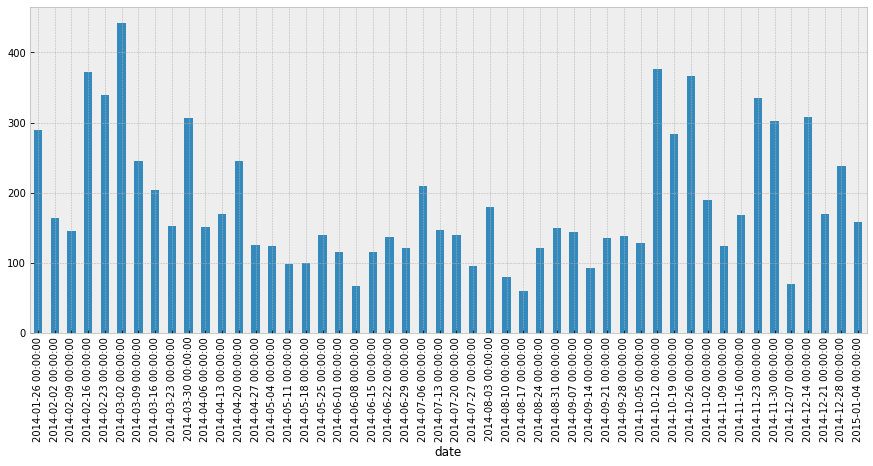

In [211]:

#Insight of pollution by Week
df['pollution_today'].resample(rule='W').max()
df['pollution_today'].resample(rule='W').max()[-50:].plot(kind='bar',figsize=(15,6))


<AxesSubplot:xlabel='date'>

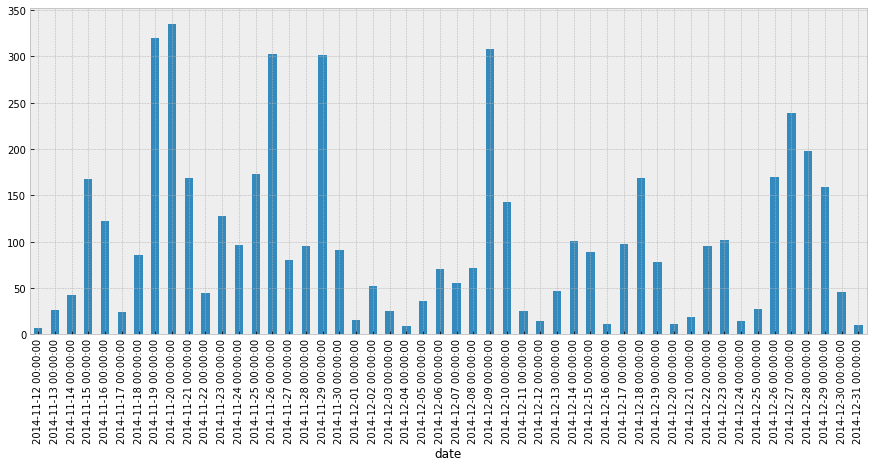

In [212]:


#Insight of pollution by Day
df['pollution_today'].resample(rule='D').max()
df['pollution_today'].resample(rule='D').max()[-50:].plot(kind='bar',figsize=(15,6))

# Decomposition of ZTime Series Dataset

In [213]:
decomposed=seasonal_decompose(df["pollution_today"][:365], model='multiplicative')


<AxesSubplot:xlabel='date'>

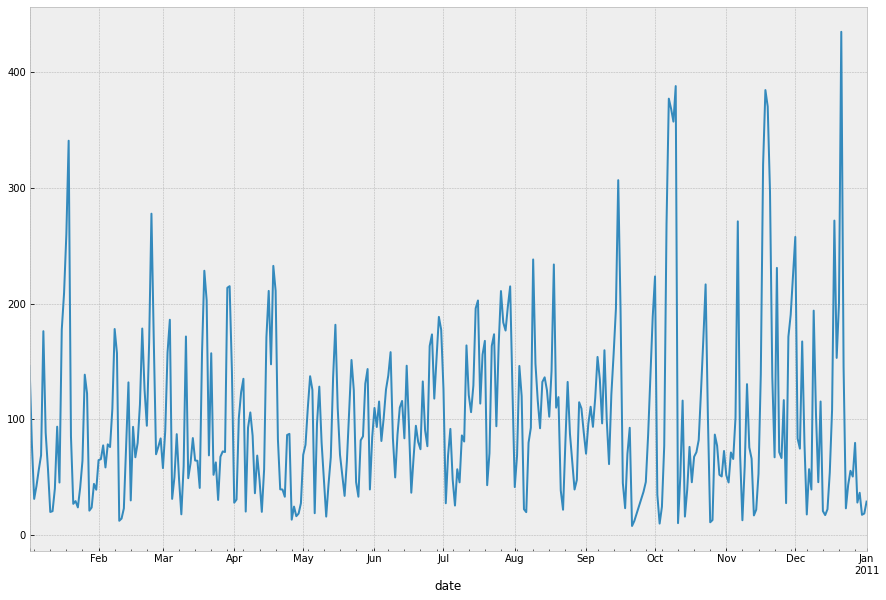

In [214]:
# original
df["pollution_today"][:365].plot(figsize=(15,10))

<AxesSubplot:xlabel='date'>

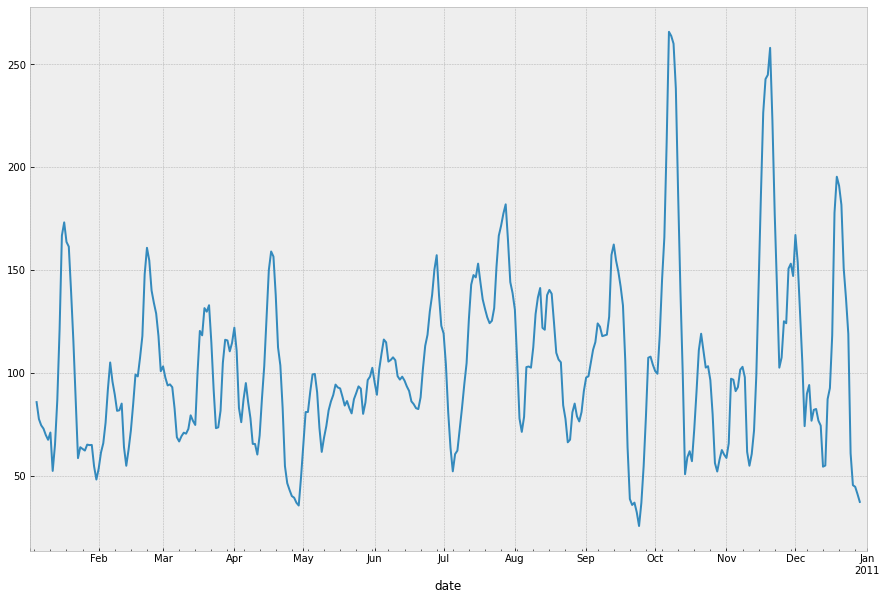

In [215]:
#Trending
decomposed.trend.plot(figsize=(15,10))

<AxesSubplot:xlabel='date'>

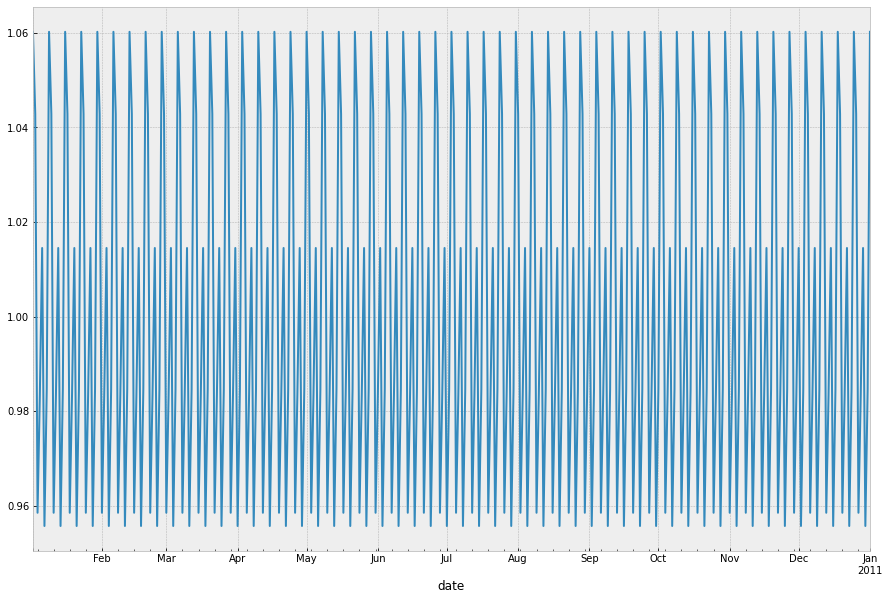

In [216]:
#Seasonality
decomposed.seasonal.plot(figsize=(15,10))

<AxesSubplot:xlabel='date'>

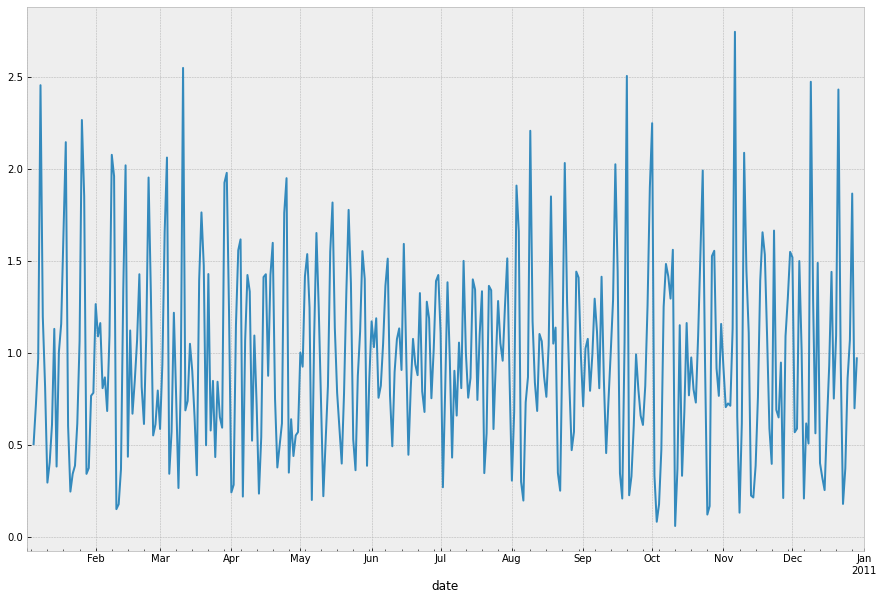

In [217]:
#Noise
decomposed.resid.plot(figsize=(15,10))

# Checking for Stationary

In [218]:
# By Dickey Fuller test

def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [219]:
adf_test(df['pollution_today'])

ADF Statistics: -10.1167190493783
p- value: 9.680895053879255e-18
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

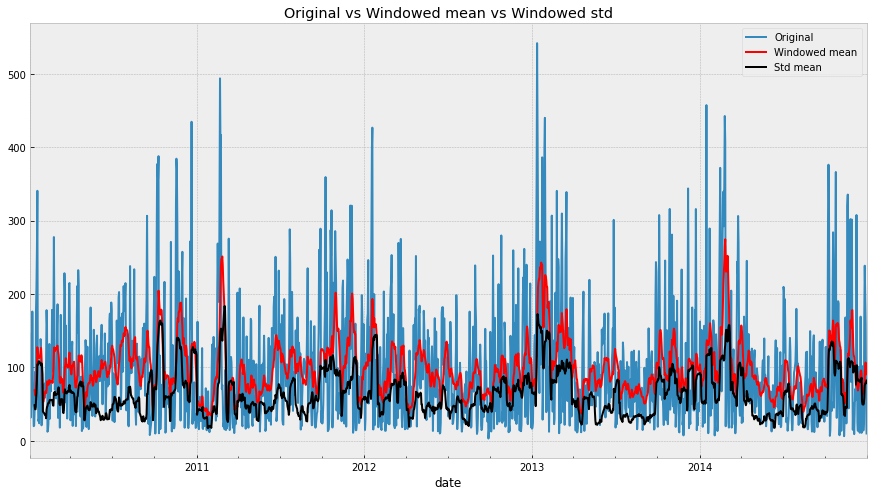

In [220]:
df['pollution_today'].plot(label='Original',figsize=(15,8))
df['pollution_today'].rolling(window=12).mean().plot(color='red', label='Windowed mean',figsize=(15,8))
df['pollution_today'].rolling(window=12).std().plot(color='black', label='Std mean',figsize=(15,8))
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

# Spliting the dataset into test and train set

In [221]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2014-01-01'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

1461 days of training data 
 364 days of testing data 


# Simple Exponential Smoothing (SES)

In [222]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train["pollution_today"])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['SES'] = yhat.values

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

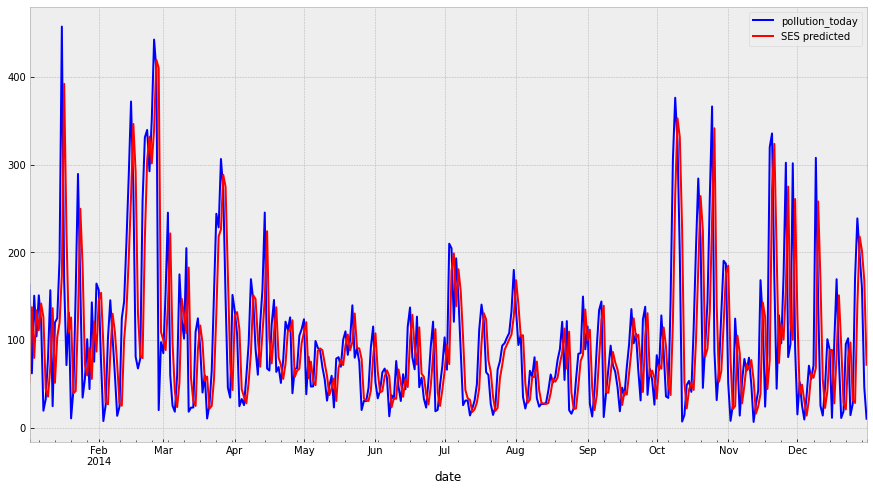

In [223]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='SES predicted',figsize=(15,8))
plt.legend()

# Holt Winter’s Exponential Smoothing (HWES)

In [224]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train["pollution_today"])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['HWES'] = yhat.values

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

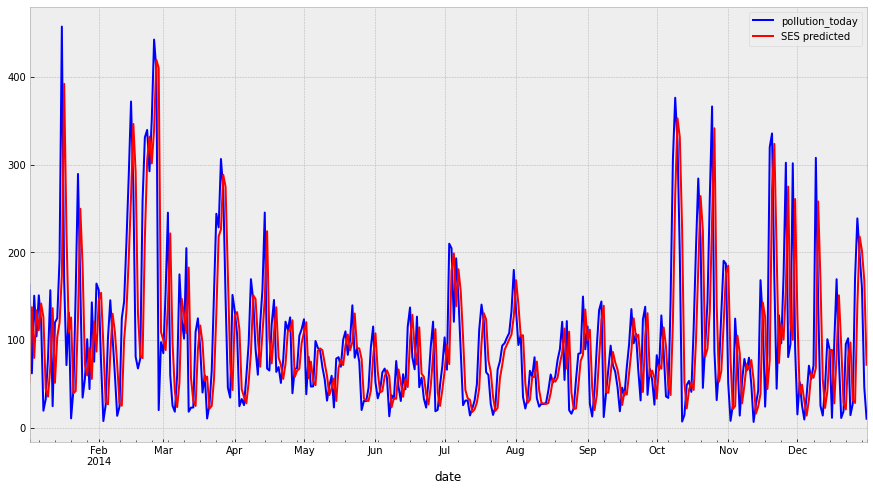

In [225]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='SES predicted',figsize=(15,8))
plt.legend()

# Autoregression (AR)


In [226]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = AR(temp_train.pollution_today)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['AR'] = yhat.values

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRE

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

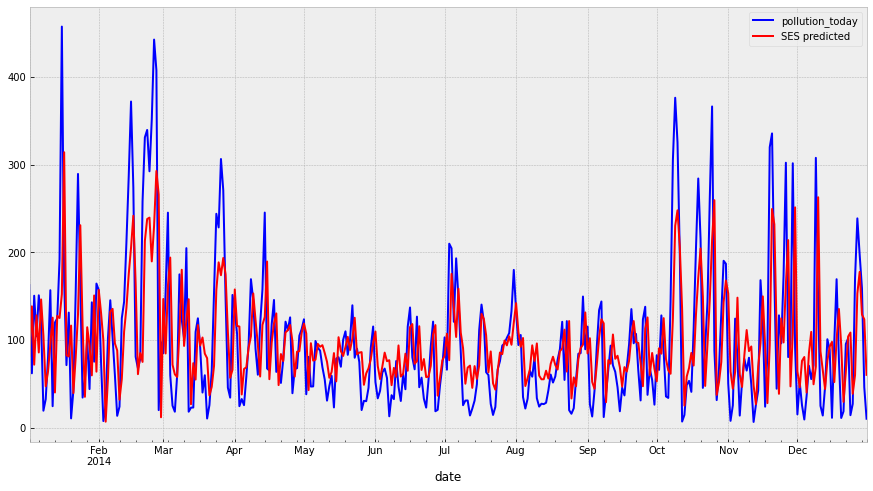

In [227]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='AR predicted',figsize=(15,8))
plt.legend()

# Moving Average (MA)

In [229]:
# MA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in range(len(df_test.pollution_today)):
    temp_train = df[:len(df_training)+t]
    model = ARMA(temp_train["pollution_today"], order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test["pollution_today"], yhat.values)
predictionsDict['MA'] = yhat.values

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No f

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

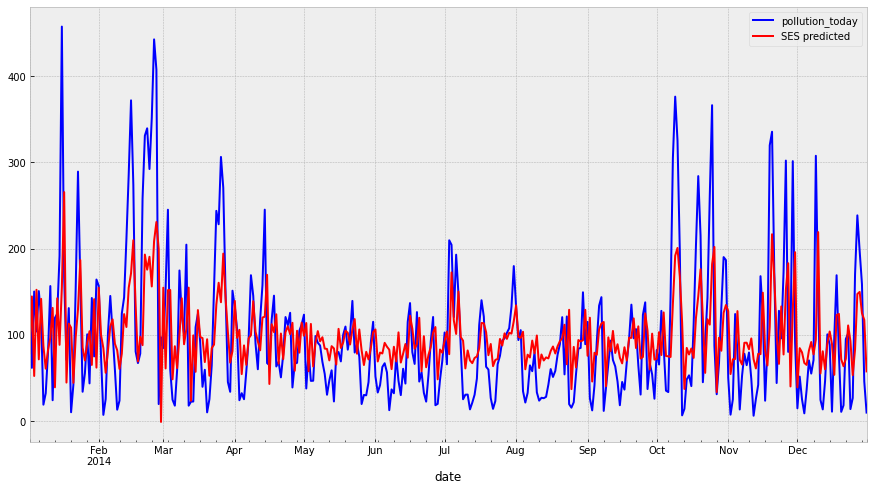

In [230]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='MA predicted',figsize=(15,8))
plt.legend()

# ACF and PACF

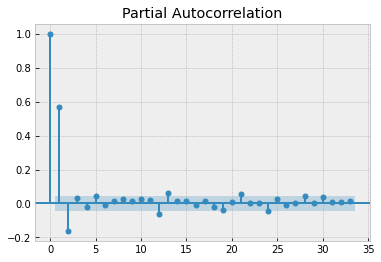

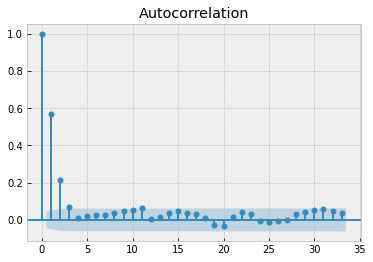

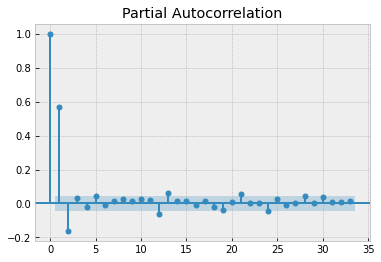

In [235]:
plot_acf(df["pollution_today"])
plot_pacf(df["pollution_today"])

# Auto Autoregressive integrated moving average (ARIMA)

In [241]:
# building the model

autoModel = pm.auto_arima(df_training["pollution_today"], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=False)
autoModel.fit(df_training["pollution_today"])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18232.724, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16461.265, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17191.945, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16462.630, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16462.086, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16455.385, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=16266.588, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16869.411, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=16217.321, Time=0.89 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=16711.266, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.90 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=2.80 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1

ARIMA(order=(0, 0, 3), scoring_args={}, suppress_warnings=True)

In [242]:
order = autoModel.order
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = ARIMA(temp_train["pollution_today"], order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test.pollution_today, yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No f

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

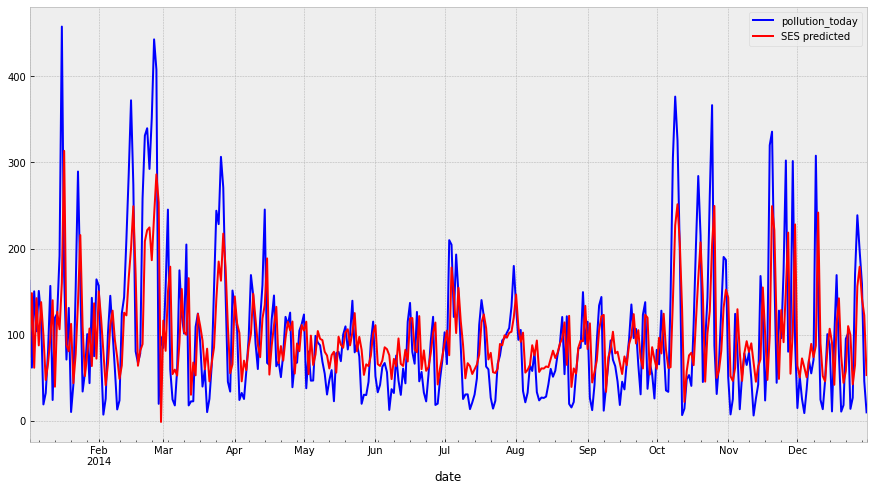

In [246]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='AutoARIMA predicted',figsize=(15,8))
plt.legend()

# Auto Seasonal Auto Regressive Integerated Moving Average (SARIMA)

In [247]:
# building the model
autoModel = pm.auto_arima(df_training["pollution_today"], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
autoModel.fit(df_training["pollution_today"])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=16199.936, Time=7.00 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=16788.406, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=16229.161, Time=0.74 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=16265.917, Time=1.66 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=18232.724, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=16200.349, Time=1.73 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=16200.355, Time=1.61 sec
 ARIMA(2,0,2)(2,0,1)[6] intercept   : AIC=16203.879, Time=4.63 sec
 ARIMA(2,0,2)(1,0,2)[6] intercept   : AIC=16203.861, Time=5.27 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=16198.453, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=16196.487, Time=1.52 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=16198.378, Time=3.69 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=16198.371, Time=3.56 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=16200.253, Time=2.57 sec
 ARIMA(0,0,2)(0,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True)

In [249]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in range(len(df_test["pollution_today"])):
    temp_train = df[:len(df_training)+t]
    model = SARIMAX(temp_train["pollution_today"], order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test.pollution_today, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ali/Downloads/TimeSeriesForecasting/env/lib/python3.6/site-packages/statsmodels/ts

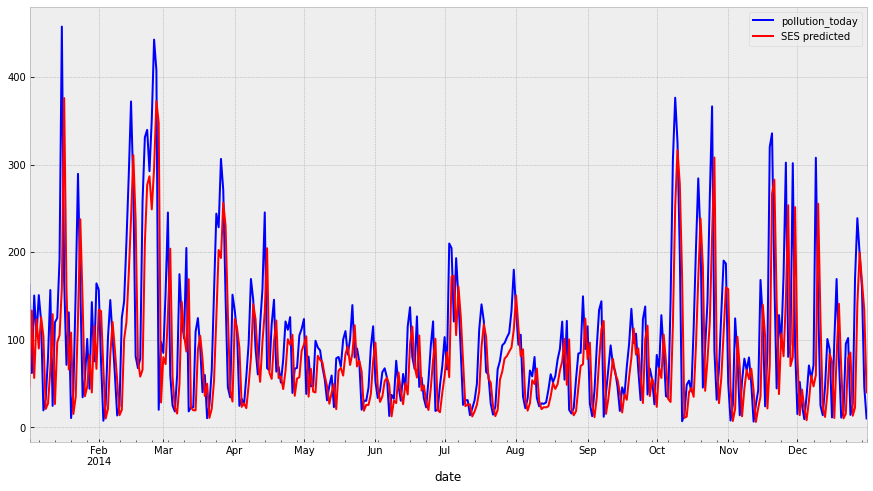

In [250]:
df_test.plot(color='blue', label='Original',figsize=(15,8))
yhat.plot(color='red', label='AutoSARIMAX predicted',figsize=(15,8))
plt.legend()


In [256]:
!pip freeze > requirements.txt